In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
with open('homework4_spikes.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times']
#     convert array into dataframe
#     DF = pd.DataFrame(spike_times)
#     # save the dataframe as a csv file
#     DF.to_csv("HW4_spike_times.csv")
# print(DF.shape)

with open('homework4_metadata.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # target onset times for each trial
    time_go_cue = metadata['time_go_cue'] # go cue time for each trial
    time_target_acquired = metadata['time_target_acquired'] # time the target was touched
    trial_reach_target = metadata['trial_reach_target'] # index of reach target for each trial (0 through 7)
    # note that I've "fixed" the reach targets to be 0-7 rather than 1-8
    target_locations = metadata['target_locations'] # x,y location of each target 
    target_angles = metadata['target_angles'] # angle of each target

In [8]:
# Verify that there are in fact two different plan period durations
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005])

In [9]:
def extract_plan_spikes(window_length=None, 
                        start_offset=None):
    # Return a matrix of spike counts in the plan window.
    # - The default plan window is defined as the time between
    #   time_touch_held and time_go_cue for each trial. NOTE:
    #   not all trials have the same duration!!!
    # - If a "window_length" is specified, return the number
    #   of spikes in the window of that duration. Return -1
    #   if the available plan period is too short for the window
    #   (for example, window_length=1000 but the trial plan
    #   period is just 755 ms). 
    # - If a "start_offset" is specified, return the number of
    #   spikes in the window defined as starting "start_offset"
    #   ms after the time_touch_held. (Use either time_go_cue
    #   or the optional window_length to determine window end.)
    #   If start_offset is so large that it extends past the
    #   time_go_cue, return -1.
    
    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held
    
    plan_spikes = []   
    for tx, trialSpikes in enumerate(spike_times):
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]
        
        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]):
                plan_spikes.append(-np.ones(len(trialSpikes)))
        else:
            plan_spikes.append(
                np.array([np.sum((st > trial_starts[tx]) & 
                        (st < trial_end)) for st in trialSpikes]))
    return np.array(plan_spikes) # will be 1127 x 190 (number of trials by number of neurons)

In [10]:
plan_spikes = extract_plan_spikes(window_length=750)
print(np.array(plan_spikes).shape)
DF = pd.DataFrame(plan_spikes)
DF.to_csv("plan_spikes.csv")

(1127, 190)


In [11]:
# select the 755 ms plan period trials for testing
short_trials = (time_go_cue - time_touch_held) == 755 # boolean array
print("short_trials", np.array(short_trials).shape)
print(short_trials)
print("Dimension of short trails")
training_trials = [] # will be 8 lists of trials
test_trials = [] # all the leftovers
for c in range(8): # reach targets go from 0 to 7
    target_trials = np.argwhere((trial_reach_target==c)).squeeze()
    # randomly select 25 training trials per direction
    random_training_trials = np.random.choice(target_trials, 25, replace=False)
    training_trials.append(random_training_trials)
    remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)
    
    test_trials.extend(remaining_test_trials)

arr1 = np.array(training_trials)
arr2 = np.array(test_trials)
print("Dimension of training trails", arr1.shape)
print(arr1)
print("Dimension of test trails", arr2.shape)
print(arr2)

short_trials (1127,)
[False False False ...  True False False]
Dimension of short trails
Dimension of training trails (8, 25)
[[ 477  907  161  233 1101   21  327  983  860  695  247  224  343  720
   909  600  428  845   55  307  457  172  933 1009  518]
 [ 200 1063 1050  850 1018  586   10  687 1082  577  994  601  661  328
   494  812  252  367  871  436  427  483  513 1033  936]
 [ 463  558 1114 1110  990  908  572  370  610  780 1043  362  949  543
   822  317  762   44  603  614  379  648  194   47  996]
 [ 944 1015  441 1083  963  683  716  856  184   17  424  992  502  313
   101  984  268  207 1045  515  740  188  121  888  460]
 [ 583  756  127  826  671  412  426  523  321  562  783  958  796  480
   819  668  823  201  108  383  890  863 1027  283  718]
 [ 660  768   80  567 1035  512  836  816   82  487   25 1068  591    8
   838  142  771  747  931  788  579  170  266  417  631]
 [  40  271  413  658  752   24    6  820  566 1088 1111  178  525  202
   520  403 1071  100 

In [12]:
# Calculate the mean spike counts per neuron for each target
num_neurons = plan_spikes.shape[1]
print("num_neurons")
print(num_neurons)
mean_spike_counts = np.zeros((num_neurons, 8))
print("mean_spike_counts")
print(mean_spike_counts)
for c in range(8):
    mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
    print("training_trials[c] at ", c)
    print(training_trials[c])
    print("plan_spikes[training_trials[c],:] at ", c)
    print(plan_spikes[training_trials[c],:])
    print("mean_spike_counts at ", c)
    print(mean_spike_counts)

num_neurons
190
mean_spike_counts
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
training_trials[c] at  0
[ 477  907  161  233 1101   21  327  983  860  695  247  224  343  720
  909  600  428  845   55  307  457  172  933 1009  518]
plan_spikes[training_trials[c],:] at  0
[[ 2  5  2 ...  8  8  6]
 [ 0  4  1 ...  6 14  6]
 [ 2  5  1 ...  8  4  2]
 ...
 [ 0  5  1 ...  8 12  4]
 [ 0  1  2 ... 10  6  7]
 [ 0  2  3 ...  8 15  7]]
mean_spike_counts at  0
[[0.56 0.   0.   ... 0.   0.   0.  ]
 [3.28 0.   0.   ... 0.   0.   0.  ]
 [2.16 0.   0.   ... 0.   0.   0.  ]
 ...
 [7.8  0.   0.   ... 0.   0.   0.  ]
 [6.72 0.   0.   ... 0.   0.   0.  ]
 [5.48 0.   0.   ... 0.   0.   0.  ]]
training_trials[c] at  1
[ 200 1063 1050  850 1018  586   10  687 1082  577  994  601  661  328
  494  812  252  367  871  436  427  483  513 1033  936]
plan_spikes[training_trials[c],:] at  1
[[ 0  6  0 ...  

In [13]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01): 
    # assume mu is (N,) and x is (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps
    return np.sum(x * np.log(mu) - mu, axis=1)

In [14]:
# Calculate probability for each target and each test trial
poisson_likelihood = np.zeros((len(test_trials), 8))    
for c in range(8):
    m = mean_spike_counts[:,c]
    poisson_likelihood[:,c] = \
        multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

In [15]:
correct_targets = trial_reach_target[test_trials] # correct target for each trial
decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
print('Poisson Correct: ', np.mean(correct_targets==decoded_targets))
print('({} test trials)'.format(len(test_trials)))

Poisson Correct:  0.9428263214670982
(927 test trials)


In [42]:
# neuron_idx = np.arange(0,190,1)

firing_rate = []
for i in mean_spike_counts:
    m = np.mean(i)
    firing_rate.append(m)
    
#neuron_idx = np.argsort(firing_rate)[:30] #smallest firing rate index
# neuron_idx = np.argsort(firing_rate)[-30:] #biggest firing rate index

# random_neurons = np.random.choice(neuron_idx, 150, replace=False)
neuron_idx = np.random.choice(range(190), 150, replace=False)


(0.0, 1.0)

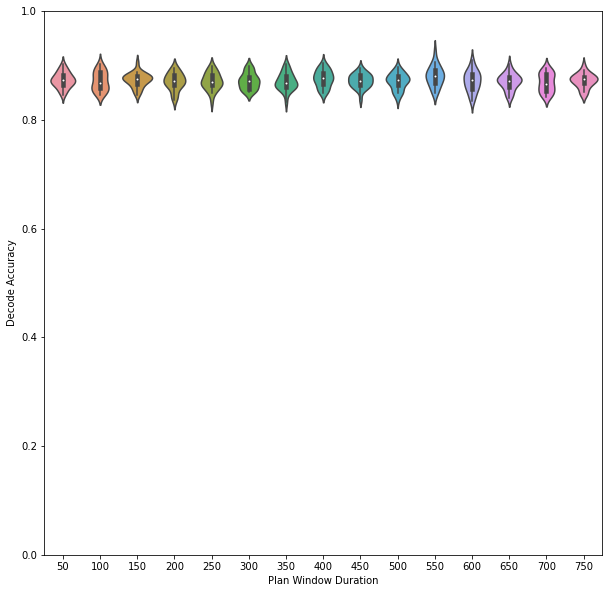

In [56]:
decode_perf = []
for plan_window in np.arange(50,800,50): # (this goes to 750!!!)
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100)  #set the length of the decode window to 250 ms
    # Before: plan_spikes = extract_plan_spikes(window_length=plan_window)
    #  change your loop to loop over an offset variable that you design to range from 0 to 500 (500 is the maximum offset that will fit for the 755 ms plan windows!)
    decode_perf.append([])
    
    # Randomly choose training and test data 25 times
    for i in range(25): 
        
        # Fill in code here to 
        #  1) randomly select training and test trials    

        # randomly select 25 training trials per direction

        training_trials = [] # will be 8 lists of trials
        test_trials = [] # all the leftovers
        for c in range(8): # reach targets go from 0 to 7
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials, 40, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        
        num_neurons = len(neuron_idx)     # Before num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        
        for c in range(8):
            #  2) calculate mean spike counts using training data
            # Before: mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
            # mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c], neuron_idx], axis=0)
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c], :][:,neuron_idx], axis=0)

        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c] 
            #  3) calculate target likelihoods for test data
            # Before: poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials, :])
            # poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials, neuron_idx])
            poisson_likelihood[:,c] = multivariate_poisson_logpdf(m, plan_spikes[test_trials, :][:, neuron_idx])
            
        #  4) decode by picking the most likely target
        correct_targets = trial_reach_target[test_trials]
        decoded_targets = np.argmax(poisson_likelihood,axis=1)
        
        # Assuming that you define the variables "correct_targets"
        #  and "decoded_targets", the follow line calculates
        #  the decoding performance for this iteration

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convert to a numpy array 
#print(decode_perf)
fig = plt.figure(figsize=(10,10))
ax = sns.violinplot(data = pd.DataFrame(np.array(decode_perf).T, columns=np.arange(50,800,50)))
ax.set(xlabel='Plan Window Duration', ylabel='Decode Accuracy')
ax.set_ylim([0, 1])

In [57]:
print(np.mean(decode_perf))

0.8726080132176787
